In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy import optimize
from scipy.optimize import curve_fit
from numpy.fft import fft, ifft, fftfreq
from scipy import signal
from scipy.signal import find_peaks

In [2]:
'''VARIABLES'''

'''
data = list of data values
sample_rate, sr = sampling frequency of sensor
dt = timing interval of sampling
FT = fourier transform of data
times = list of values from time column

'''
## RELEVANT FILE PATH HERE: ##
file_path = r'C:\Users\Ellie\Desktop\third year\Group studies\Ellie_code_test1.csv'

E1 = 'E1'
E2 = 'E2'
E3 = 'E3'
E4 = 'E4'
E5 = 'E5'
T = 'T'            # nb. relevant gyroscope axis = Y, relevant acc axes = X, Z
AX = 'AX'
AY = 'AY'
AZ = 'AZ'
GX = 'GX'
GY = 'GY'
GZ = 'GZ'

COLUMNS = [E1, E2, E3, E4, E5, T, AX, AY, AZ, GX, GY, GZ] # all column headings in data set


'''CONVERTING COLUMN TO ARRAY OR LIST (only necessary for analysis, can just use raw list during live swinging)'''

def column_to_array(file_path, column):
    d = pd.read_csv(file_path, header=None, names=COLUMNS) # reads columns in data file
    c = column                                             # isolates target column and coverts to array
    col = pd.DataFrame(d, columns = [column])
    col_array = np.array(col)
    big_array = np.concatenate(col_array)                  # converts column array into 1 large array
    return big_array


def column_to_list(file_path, column):
    big_array = column_to_array(file_path, column)
    big_list = big_array.tolist()  # converts column array to list
    return big_list

'''FINDING FREQUENCIES/PERIODS FFT'''

def plot_ft(data, sample_rate):
    '''
    Plots Fourier transform data
    '''
    X = fft(data)                 # executes fft of data
    N = len(X)
    n = np.arange(N)
    time = N/sample_rate          # finds total time sampled
    freq = n/time                 # sampling frequency 
    plt.figure(figsize = (12, 6)) # plots fft
    plt.subplot()
    amp = np.abs(X)               # finds peaks
    amp_list = amp.tolist()
    max_amp = max(amp_list)       #finds maximum amplitude of all peaks
#     print(max_amp)
    plt.stem(freq, amp/max_amp, 'b', markerfmt=" ", basefmt="-b") # normalised fft, so peak = 1
    plt.xlim(0.001, 2.5)
    plt.xlabel('Freq (Hz)')
    plt.ylabel('Normalised FFT Amplitude |X(freq)|')
    plt.title('Normalised FFT')
    plt.grid()
    return plt.show()

def plot_ift(data, times):
    '''
    Plots inverse Fourier transform data (to check FFT function)
    '''
    X = fft(data)                 # calculates fft
    plt.figure(figsize = (12, 6))
    plt.plot(times, ifft(X), 'r') # plots ift
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    return plt.show()

def find_freq(data, sample_rate):
    '''
    Finds frequency of peak in FFT
    '''
    X = fft(data)
    N = len(X)
    n = np.arange(N)
    time = N/sample_rate
    freq = n/time
#     print(freq)
    amp = np.abs(X)                 # finds maximum fft amplitude
    amp_list = amp.tolist()
    max_amp = max(amp_list[1:])     # finds maximum (ignoring points at 0 which distort result)
    index = amp_list.index(max_amp) # finds index of maximum in fft data
    f = freq[index]                 # finds corresponding frequency
    return f


def transform_curve(data, sample_rate):
    '''
    Plots the FFT as a curve
    '''
    plt.figure(figsize = (20, 10))
    plt.subplot()
    ft = np.fft.fft(data)          # calculates fft
    amp = np.abs(ft)
    amp_list = amp.tolist()
    max_amp = max(amp_list)        # finds maximum fft peak
    freq = np.fft.fftfreq(len(ft)) # finds frequency of peak
    dt = 1/sample_rate
    x = freq[1:]/dt
    y = (ft[1:].real**2 + ft[1:].imag**2)**(0.5) # calculates magnitude of peak
    max_y = max(y)
    plt.xlim(0,)
    plt.xlabel('Frequency (Hz)', fontsize = 25)
    plt.ylabel('Normalised Amplitude', fontsize=25)
    plt.grid()
#     plt.labelsize(20)
    return plt.plot(x, y/max_y, 'r') # plots magnitude vs frequency

Fundamental frequency is: 0.39


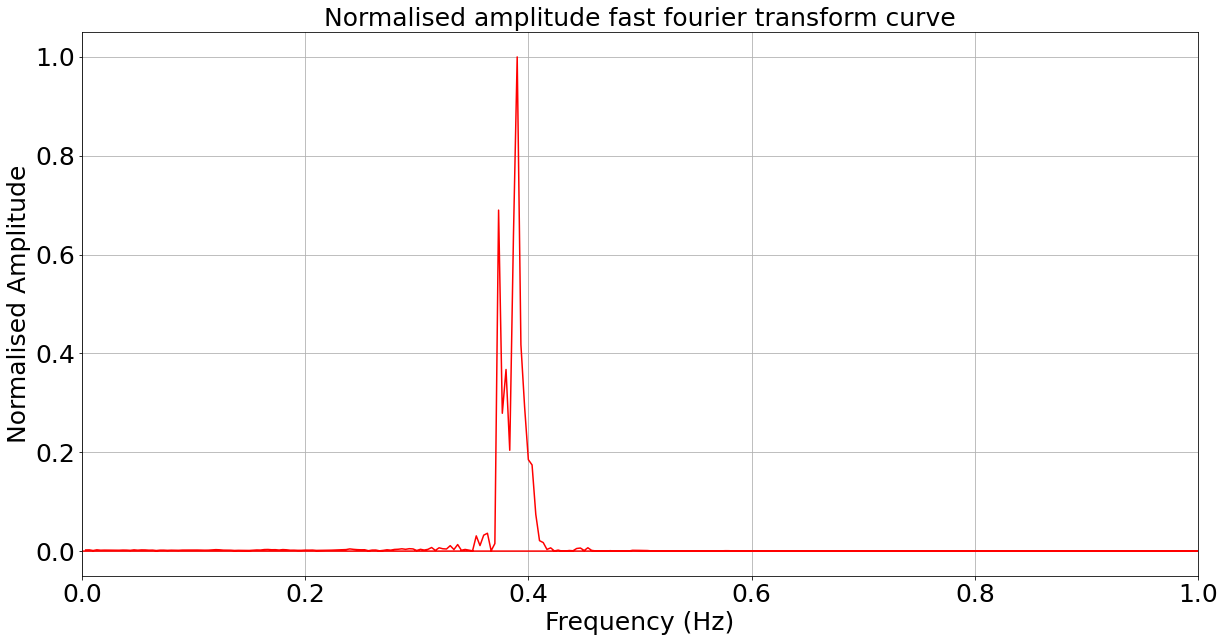

In [3]:
'''TESTS'''

sr = 5
dt = 1/sr

test_column_A = E1

A = column_to_list(file_path, test_column_A)
E = column_to_list(file_path, E1)
Time = column_to_list(file_path, T)

# plt.plot(Time, A)

b = column_to_array(file_path, AZ)
t = column_to_array(file_path, T)

f = find_freq(A, sr)
print('Fundamental frequency is:', f)

transform_curve(A, sr)
plt.title('Normalised amplitude fast fourier transform curve', fontsize = 25)
plt.xticks(fontsize = 25)
plt.yticks(fontsize = 25)
plt.show()

Using FFTs for Forecasting:

In [4]:
def iterate(point, step, n):
    return point + n*step

def predict(data_list, times_list, sample_rate, L, N):
    A = data_list
    A1 = A[L-N:L]     # last N points

    f1 = find_freq(A1, sr)
    
    '''Note : 
        for Z acceleration, the highest frequency fourier peak = 0.8 Hz; this is what should be measured by find_freq.
        for all other data, fundamental frequency = 0.39 Hz '''

    mpp = sr/f1                      # measurements per period
    peak_diff = np.math.ceil(2*mpp)  # list indices per period, rounded to next integer
    Max = np.max(A1)
    index_A1 = A1.index(Max)
    index_A = (L-N)+index_A1
    indices = []
    for n in np.arange(1, 10): # checks to make sure that the next predicted time hasn't already passed
        if L-N < iterate(index_A, peak_diff, n) < L:
            new_index = iterate(index_A, peak_diff, n)
            indices.append(new_index)
            continue # if peak has already passed
        if iterate(index_A, peak_diff, n) > L:
            new_index = iterate(index_A, peak_diff, n)
            indices.append(new_index)
            break # if peak has not passed

    return indices

In [5]:
''' Testing for a window of static data '''

L = len(A)
N = 75
next_kick = predict(A, Time, sr, L, N)                       # finds measurement indices of future kicks
print('Index of next predicted peak in window =', next_kick) # When kick_time is reached, Nao should react

'''Predicting for a set of static data'''

kick_points = []

for k in np.arange(N, L, N):
    kick = predict(A, Time, sr, k, N) # finds measurement indices of future kicks
    kick_points.append(kick)          # creates list of theoretical kick points relative to starting point
final_kick_points = np.concatenate(kick_points) # combines all kick points
    
print('Indices of kick points are', final_kick_points)

Index of next predicted peak in window = [1456, 1481, 1506]
Indices of kick points are [   4    7   10   13   16   19   22   25   28  107  132  157  182  207
  232  271  296  321  314  317  320  323  326  329  332  335  338  401
  426  451  478  503  528  547  550  553  556  559  562  565  568  571
  634  659  684  700  725  775  780  805  830  861  886  911  928  953
  978 1006 1031 1056 1092 1122 1152 1155 1180 1205 1236 1261 1286 1303
 1328 1353 1383 1408 1433]


This needs improving to correlate indices with a time, and also allow parsing of live data, rather than static. (Discussion in report, 2022)